# Slovak Parliamentary LLM Benchmark - Semantic Search Analysis 🇸🇰

## 📊 Research Overview

This notebook implements **novel evaluation procedures for embedding models** on Slovak parliamentary transcriptions from 2010-2023. 

#### 1. Context-Aware Unique Content Extraction
- **Innovation**: Speaker-context awareness for parliamentary speeches
- **Slovak-Specific**: Tailored prompting for Slovak political discourse  
- **Three Tasks**:
  - `unique_literal`: Doslovné výroky (literal statements)
  - `unique_paraphrase`: Parafrázované výroky (paraphrased content)
  - `unique_question`: Otázky na faktický obsah (factual questions)

#### 2. Cross-Linguistic Embedding Evaluation
- **Methodology**: Slovak→English semantic preservation assessment
- **Models Tested**: OpenAI (Large/Small), Gemini, Voyage, Mistral
- **Metrics**: Recall@k, MRR@k, Precision@k, nDCG@k

#### 3. Parliamentary Domain-Specific Benchmarking
- **Context**: Legislative discourse analysis
- **Uniqueness**: First comprehensive embedding evaluation on Slovak political data
- **Applications**: Policy analysis, legislative research, political discourse studies

## 📋 Notebook Workflow

### Phase 1: Data Preparation & Filtering
1. **Load Corpus**: Slovak parliamentary transcriptions 
2. **Token Filtering**: Select optimal range (2K-6K tokens)
3. **Sampling**: Extract 500 representative speeches
4. **API Setup**: Initialize OpenAI, Gemini, Mistral, Voyage clients

### Phase 2: Novel Content Extraction (Gemini)
5. **Context-Aware Extraction**: Generate unique content with speaker context
   - Extract `unique_literal` statements using Slovak parliamentary prompts
   - Generate `unique_paraphrase` reformulations  
   - Create `unique_question` factual queries
6. **Error Recovery**: Retry failed extractions with exponential backoff

### Phase 3: Multi-Model Embedding Generation
7. **OpenAI Embeddings**: Large (3072d) and Small (1536d) models
8. **Gemini Embeddings**: Google's multilingual model (3072d)
9. **Voyage Embeddings**: Specialized retrieval model (2048d)  
10. **Mistral Embeddings**: European multilingual model (1024d)

### Phase 4: Semantic Search Benchmark
11. **Similarity Computation**: Cosine similarity between query-document pairs
12. **Retrieval Evaluation**: Multi-metric assessment (Recall, MRR, Precision, nDCG)
13. **Comparative Analysis**: Cross-model performance on Slovak parliamentary tasks



---


In [1]:
import pandas as pd
from google import genai
import os
from dotenv import load_dotenv
from mistralai import Mistral
from openai import OpenAI
import voyageai
import numpy as np
import time
from sklearn.metrics import ndcg_score
from google.genai import types
import matplotlib.pyplot as plt
from itertools import product
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm

In [ ]:
df = pd.read_parquet(r"..\data\df_to_app_with_openAI_S_L_voyage_gdoogle_mistral_embeddings_navrh_zakona_obdobie_8.parquet", engine="fastparquet")

In [3]:
load_dotenv(r"..\keys.env")

True

In [4]:
openai_api_key = os.getenv("OPENAI_API_KEY")
google_api_key = os.getenv("GOOGLE_API_KEY")
Mistral_API_KEY = os.getenv("MISTRAL_API_KEY")
VOYAGE_API_KEY = os.getenv("VOYAGE_API_KEY")


In [5]:
vo = voyageai.Client(api_key=VOYAGE_API_KEY)
client_mistral = Mistral(api_key=Mistral_API_KEY)
client_google = genai.Client(api_key=google_api_key)
client = OpenAI(api_key=os.getenv('OPENAI_API_KEY'))

<Axes: >

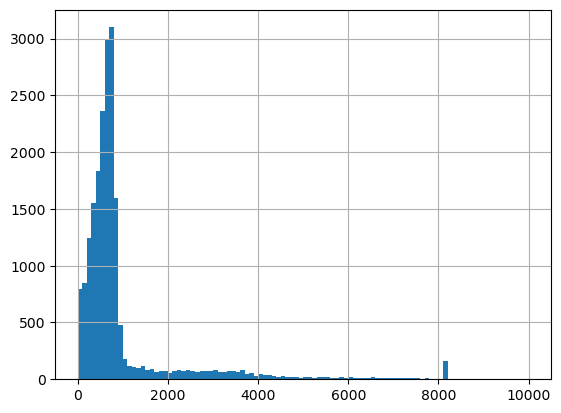

In [6]:
df.num_tokens_mistral.hist(bins=100, range=(0, 10000), log=False)

<Axes: >

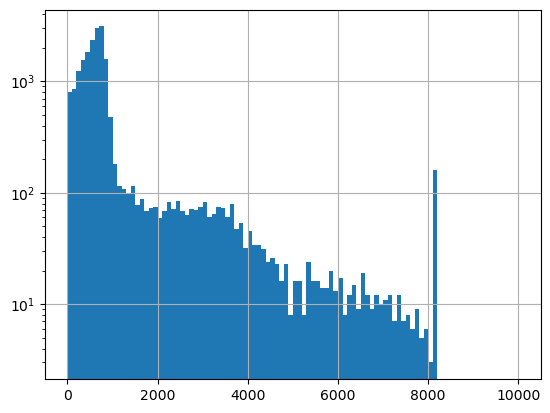

In [7]:
df.num_tokens_mistral.hist(bins=100, range=(0, 10000), log=True)

In [31]:
# --- Semantic Search Embedding Test Setup ---
# 1. Filter out rows where num_tokens_mistral > 4000
df_filtered = df[(df.num_tokens_mistral > 2000)& (df.num_tokens_mistral < 6000)].copy()

# For quick testing, sample only 10 rows
df_sample = df_filtered.sample(n=500, random_state=42).reset_index(drop=True)

In [23]:
# --- Gemini unique literal, paraphrase, and question functions (Slovak prompts, with context, model role, temperature=0.1) ---


def extract_unique_literal_gemini(text, context=None):
    system_prompt = (
        "Si expert na slovenské parlamentné prejavy. Tvojou úlohou je vybrať doslovne tri vety, ktoré sú jedinečné pre daný text. "
        "Neparafrázuj, len skopíruj časť, ktorá sa pravdepodobne nevyskytuje v iných prejavoch alebo v kontexte. "
        "Výroky by mali odrážať jedinečné myšlienky alebo fakty, ktoré sú špecifické pre tento text, a nemali by byť všeobecné. "
        "Odpoveď sú len výroky z textu, nič viac."
    )
    user_prompt = (
        (f"KONTEXT: {context}\n" if context else "") +
        "Text: " + text + "\n\nJedinečný úryvok:"
    )
    try:
        response = client_google.models.generate_content(
            model="gemini-2.5-flash-lite",
            contents=[
                {"role": "model", "parts": [{"text": system_prompt}]},
                {"role": "user", "parts": [{"text": user_prompt}]},
            ],
            config=types.GenerateContentConfig(temperature=0.1)
        )
        return response.text.strip() if hasattr(response, 'text') else str(response)
    except Exception as e:
        print(f"Gemini API error: {e}")
        return None

def paraphrase_unique_gemini(text, context=None):
    system_prompt = (
        "Si expert na slovenské parlamentné prejavy. Tvojou úlohou je parafrázovať krátku časť (3 vety), ktorá je jedinečná pre daný text. "
        "Nekopíruj doslovne, ale preformuluj jedinečnú myšlienku alebo fakt z textu. Odpoveď sú len parafrázované výroky z textu, nič viac."
    )
    user_prompt = (
        (f"KONTEXT: {context}\n" if context else "") +
        "Text: " + text + "\n\nParafrázovaný jedinečný úryvok:"
    )
    try:
        response = client_google.models.generate_content(
            model="gemini-2.5-flash",
            contents=[
                {"role": "model", "parts": [{"text": system_prompt}]},
                {"role": "user", "parts": [{"text": user_prompt}]},
            ],
            config=types.GenerateContentConfig(temperature=0.1)
        )
        return response.text.strip() if hasattr(response, 'text') else str(response)
    except Exception as e:
        print(f"Gemini API error: {e}")
        return None

def generate_question_gemini(text, context_questions=None):
    system_prompt = (
        "Si expert na slovenské parlamentné prejavy. Tvojou úlohou je vytvoriť otázku, ktorá by bola jedinečná pre daný text a nebola by opakovaním otázok z kontextu. "
        "Otázka má byť formulovaná tak, že obsahuje otázku na fakt v texte. "
        "Je jednoduchá a priamočiara, zameraná na konkrétny fakt alebo informáciu v texte\n"
        "V žiadnom prípade sa nepýtaj na to, čo povedal rečník v texte,alebo hovorí zákon v texte.\n"
      
       
   
    )
    if context_questions:
        safe_list = [q for q in context_questions if q]   # drop None / ""
        context_block = (
            "Tieto otázky už existujú, NEopakuj ich: "
            + " ; ".join(safe_list) + "\n"
        )
    else:
        context_block = ""

    user_prompt = (f"""
        "Inštrukcie:\n"
        "1. Prečitaj si text a zisti, aké jedinečné informácie obsahuje.\n" 
        "2. Vytvor otázku, ktorá sa týka konkrétneho faktu alebo informácie v texte.\n" 
        "3. “Vytvor novú otázku, ktorá sa nezhoduje s žiadnou z nasledujúcich v kontexte” \n"
        "4. Nezabudni, že otázka by mala byť formulovaná tak, že obsahuje otázku na fakt v texte, ale nie čo o tom povedal o tom rečník v texte.\n"
          "...................................\n"
        "Príklad dobrej otázky: Koľko percent z celkového vybraného poistného dostalo Národné centrum zdravotníckych informácií v roku 2018?\n"
        "Príklad dobrej otázky: Aké sú hlavné ciele spôsobilostí NATO pre Slovenskú republiku podľa obrannej stratégie?\n"
        "..................................\n"
        "Príkalad zlej otázky:Aké je percento súkromných vlastníkov lesov, ktorých sa dotkne predkladaný zákon?"
        "Príklad zlej otázky: Aké sú hlavné ciele predkladaného zákona?\n"
        "Príklad zlej otázky:Koľko náboženstiev existuje na svete podľa slov poslanca?\n"
        "..................................\n"
        "Predošlé otázky:"           
        {context_block}
        "Text:" {text} + "\n\nOtázka:" """
    )
    try:
        response = client_google.models.generate_content(
            model="gemini-2.5-flash-lite",
            contents=[
                {"role": "model", "parts": [{"text": system_prompt}]},
                {"role": "user", "parts": [{"text": user_prompt}]},
            ],
            config=types.GenerateContentConfig(temperature=0.1)
        )
        return response.text.strip() if hasattr(response, 'text') else str(response)
    except Exception as e:
        print(f"Gemini API error: {e}")
        return None

In [24]:
# --- Voyage embedding function ---
def embed_truncated_prepis_voyage(df, model, input_type, output_dimension, text_column, out_column, batch_size=25, delay=60):
    """
    Embeds a DataFrame column using VoyageAI's embedding API in batches.
    Args:
        df: pandas DataFrame
        model: VoyageAI model name (e.g., 'voyage-2', 'voyage-01', etc.)
        input_type: 'query' or 'document' (see VoyageAI docs)
        output_dimension: embedding dimension (e.g., 1024)
        text_column: column to embed
        out_column: output column for embeddings
        batch_size: batch size for API calls
        delay: seconds to wait after a rate limit error
    Returns:
        DataFrame with new embedding column
    """
    texts = df[text_column].astype(str).tolist()
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        try:
            result = vo.embed(
                batch,
                model=model,
                input_type=input_type,  # must be 'query' or 'document'
                output_dimension=output_dimension
            )
            embeddings.extend(result.embeddings)
        except voyageai.error.RateLimitError:
            print("Rate limit hit, waiting before retrying...")
            import time
            time.sleep(delay)
            # Retry the same batch
            result = vo.embed(
                batch,
                model=model,
                input_type=input_type,
                output_dimension=output_dimension
            )
            embeddings.extend(result.embeddings)
        except Exception as e:
            print(f"Voyage embedding error: {e}. Filling with None.")
            embeddings.extend([None]*len(batch))
    df[out_column] = embeddings
    return df



In [25]:
def embed_single_mistral(text, model="mistral-embed", lock=None, max_retries=5, base_wait=5):
    """
    Generate Mistral embeddings for Slovak parliamentary transcription effectiveness analysis
    Returns only the embedding vector for 2010-2023 corpus research
    """
    if not isinstance(text, str) or not text.strip():
        return None
    
    # Check if client is properly initialized
    global client_mistral
    if client_mistral is None:
        print("❌ Mistral client not initialized for Slovak parliamentary analysis")
        return None
    
    for attempt in range(max_retries):
        try:
            response = client_mistral.embeddings.create(
                model=model, 
                inputs=[text]  # Correct parameter for Mistral API
            )
            
            # Extract only the embedding vector from response
            if hasattr(response, "data") and isinstance(response.data, list) and len(response.data) > 0:
                # Get the embedding object
                embedding_obj = response.data[0]
                
                # Extract vector from embedding object
                if hasattr(embedding_obj, 'embedding'):
                    return embedding_obj.embedding  # Return just the vector
                elif isinstance(embedding_obj, dict) and 'embedding' in embedding_obj:
                    return embedding_obj['embedding']  # Return just the vector
                else:
                    print(f"⚠️ Unexpected Mistral response structure: {type(embedding_obj)}")
                    return None
            else:
                print("⚠️ No embeddings in Mistral response for Slovak parliamentary text")
                return None
                
        except Exception as e:
            if "rate limit" in str(e).lower() or "429" in str(e):
                wait = base_wait * (2 ** attempt)
                print(f"Rate limit hit. Waiting {wait}s before retrying (attempt {attempt+1}/{max_retries})...")
                time.sleep(wait)
            else:
                print(f"Mistral embedding error: {e}")
                return None
    
    print("Max retries reached for Mistral embedding. Skipping.")
    return None



In [26]:
def embed_mistral_rowwise(df, model, text_column, out_column):
    """
    Generate Mistral embeddings for Slovak parliamentary effectiveness analysis
    Embeds each row individually with progress tracking for 2010-2023 corpus
    Returns only embedding vectors (not embedding objects)
    """
    embeddings = []
    successful_embeddings = 0
    
    for text in tqdm(df[text_column], desc="Mistral embedding for Slovak parliament"):
        emb = embed_single_mistral(text, model)
        embeddings.append(emb)
        if emb is not None:
            successful_embeddings += 1
    
    df[out_column] = embeddings
    print(f"✅ Mistral embeddings: {successful_embeddings}/{len(embeddings)} Slovak parliamentary speeches processed")
    return df


In [27]:
def embed_gemini_google(df, text_column, out_column, output_dim=3072, batch_size=16):
    """
    Generate Gemini embeddings for Slovak parliamentary transcription effectiveness analysis
    Specialized for English-translated Slovak parliamentary speeches (2010-2023 corpus)
    Novel procedures for cross-linguistic embedding evaluation on Slovak language data
    """
    client = genai.Client()
    embeddings = []
    texts = df[text_column].tolist()
    
    for i in tqdm(range(0, len(texts), batch_size), desc="Gemini embedding for Slovak parliament"):
        batch = texts[i:i+batch_size]
        for text in batch:
            try:
                # Correct API call for Gemini embeddings
                result = client.models.embed_content(
                    model="gemini-embedding-001",
                    contents=text,
                    config=types.EmbedContentConfig(output_dimensionality=output_dim)
                )
                
                # Fix: Extract embedding vector from response
                # The embedding is in result.embeddings[0].values
                if hasattr(result, 'embeddings') and len(result.embeddings) > 0:
                    embedding_vector = result.embeddings[0].values
                    embeddings.append(embedding_vector)
                else:
                    print(f"No embeddings found in response for Slovak parliamentary text")
                    embeddings.append(None)
                    
            except Exception as e:
                print(f"Gemini embedding error for Slovak parliamentary analysis: {e}")
                embeddings.append(None)
    
    df[out_column] = embeddings
    print(f"✅ Gemini embeddings generated for {len([e for e in embeddings if e is not None])}/{len(embeddings)} Slovak parliamentary speeches")
    return df

In [70]:
def embed_openai_batch(df, text_column, out_column="openAI_embedding_3076", model="text-embedding-3-large", batch_size=16, delay=60):
    """
    Generate OpenAI embeddings for Slovak parliamentary transcription effectiveness analysis
    Extracts embedding vectors for Slovak language corpus (2010-2023)
    
    Args:
        df: DataFrame with Slovak parliamentary transcriptions
        text_column: column to embed ('prepis', 'unique_literal', etc.)
        out_column: output column for embedding vectors
        model: OpenAI embedding model for Slovak parliamentary analysis
        batch_size: texts per API call for Slovak corpus processing
        delay: wait time after rate limit for parliamentary data
        
    Returns:
        DataFrame with embedding vectors for Slovak parliamentary effectiveness evaluation
    """
    texts = df[text_column].astype(str).tolist()
    embeddings = []
    
    for i in tqdm(range(0, len(texts), batch_size), desc=f"OpenAI embeddings ({model})"):
        batch = texts[i:i+batch_size]
        try:
            response = client.embeddings.create(input=batch, model=model)
            # Extract embedding vectors directly for Slovak parliamentary analysis
            batch_embeddings = [item.embedding for item in response.data]
            embeddings.extend(batch_embeddings)
            
        except Exception as e:
            print(f"OpenAI embedding error for Slovak parliamentary text: {e}. Retrying after {delay}s...")
            time.sleep(delay)
            try:
                response = client.embeddings.create(input=batch, model=model)
                # FIXED: Use same extraction method for retry - just vectors
                batch_embeddings = [item.embedding for item in response.data]
                embeddings.extend(batch_embeddings)
                
            except Exception as e2:
                print(f"Failed again for Slovak parliamentary batch: {e2}. Filling with None.")
                embeddings.extend([None] * len(batch))
    
    df[out_column] = embeddings
    print(f"✅ OpenAI embeddings: {len([e for e in embeddings if e is not None])}/{len(embeddings)} Slovak parliamentary speeches processed")
    return df


In [33]:
# Ensure required columns exist before extraction loop
for col in ['unique_literal', 'unique_paraphrase', 'unique_question']:
    if col not in df_sample.columns:
        df_sample[col] = None
df_sample.sort_values(['Predkladateľ', 'Date', 'StartTime'], inplace=True)
df_sample = df_sample.reset_index(drop=True)

for idx, row in tqdm(df_sample.iterrows(), total=len(df_sample), desc="Extracting with Gemini"):
    speaker = row['Predkladateľ']
    text = row['prepis']

    prev_rows = df_sample.loc[:idx-1]  # all rows *before* current

    def last_n(col, n):
        return prev_rows.loc[prev_rows['Predkladateľ'] == speaker, col].dropna().tail(n).tolist()

    context_literal    = '\n'.join(last_n('unique_literal', 10)) or None
    context_paraphrase = '\n'.join(last_n('unique_paraphrase', 10)) or None
    context_questions  = last_n('unique_question', 10) or None  # keep as list

    literal    = extract_unique_literal_gemini(text, context=context_literal)
    paraphrase = paraphrase_unique_gemini(text, context=context_paraphrase)
    question   = generate_question_gemini(text, context_questions=context_questions)

    df_sample.at[idx, 'unique_literal']    = literal
    df_sample.at[idx, 'unique_paraphrase'] = paraphrase
    df_sample.at[idx, 'unique_question']   = question


Extracting with Gemini:   7%|▋         | 34/500 [07:36<1:41:49, 13.11s/it]

Gemini API error: 500 INTERNAL. {'error': {'code': 500, 'message': 'An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting', 'status': 'INTERNAL'}}


Extracting with Gemini:  14%|█▍        | 71/500 [16:20<1:48:48, 15.22s/it]

Gemini API error: 500 INTERNAL. {'error': {'code': 500, 'message': 'An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting', 'status': 'INTERNAL'}}


Extracting with Gemini:  17%|█▋        | 84/500 [19:31<1:49:22, 15.78s/it]

Gemini API error: 500 INTERNAL. {'error': {'code': 500, 'message': 'An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting', 'status': 'INTERNAL'}}


Extracting with Gemini:  24%|██▎       | 118/500 [26:40<1:20:57, 12.72s/it]

Gemini API error: 500 INTERNAL. {'error': {'code': 500, 'message': 'An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting', 'status': 'INTERNAL'}}


Extracting with Gemini:  31%|███       | 155/500 [35:21<1:54:18, 19.88s/it]

Gemini API error: 500 INTERNAL. {'error': {'code': 500, 'message': 'An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting', 'status': 'INTERNAL'}}


Extracting with Gemini:  34%|███▎      | 168/500 [38:00<1:06:32, 12.03s/it]

Gemini API error: 'NoneType' object has no attribute 'strip'


Extracting with Gemini:  37%|███▋      | 183/500 [46:21<1:12:22, 13.70s/it]

Gemini API error: 500 INTERNAL. {'error': {'code': 500, 'message': 'An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting', 'status': 'INTERNAL'}}


Extracting with Gemini:  41%|████      | 204/500 [51:31<1:06:39, 13.51s/it]

Gemini API error: 500 INTERNAL. {'error': {'code': 500, 'message': 'An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting', 'status': 'INTERNAL'}}


Extracting with Gemini:  41%|████      | 206/500 [51:56<1:04:01, 13.07s/it]

Gemini API error: 500 INTERNAL. {'error': {'code': 500, 'message': 'An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting', 'status': 'INTERNAL'}}


Extracting with Gemini:  42%|████▏     | 208/500 [52:27<1:09:45, 14.34s/it]

Gemini API error: 500 INTERNAL. {'error': {'code': 500, 'message': 'An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting', 'status': 'INTERNAL'}}


Extracting with Gemini:  43%|████▎     | 215/500 [55:02<1:37:12, 20.47s/it]

Gemini API error: 500 INTERNAL. {'error': {'code': 500, 'message': 'An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting', 'status': 'INTERNAL'}}


Extracting with Gemini:  44%|████▍     | 220/500 [56:16<1:23:52, 17.97s/it]

Gemini API error: 500 INTERNAL. {'error': {'code': 500, 'message': 'An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting', 'status': 'INTERNAL'}}
Gemini API error: 500 INTERNAL. {'error': {'code': 500, 'message': 'An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting', 'status': 'INTERNAL'}}


Extracting with Gemini:  48%|████▊     | 238/500 [1:01:03<1:17:51, 17.83s/it]

Gemini API error: 500 INTERNAL. {'error': {'code': 500, 'message': 'An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting', 'status': 'INTERNAL'}}


Extracting with Gemini:  49%|████▉     | 245/500 [1:02:36<59:05, 13.90s/it]  

Gemini API error: 500 INTERNAL. {'error': {'code': 500, 'message': 'An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting', 'status': 'INTERNAL'}}


Extracting with Gemini:  51%|█████▏    | 257/500 [1:05:22<1:00:21, 14.90s/it]

Gemini API error: 500 INTERNAL. {'error': {'code': 500, 'message': 'An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting', 'status': 'INTERNAL'}}


Extracting with Gemini:  56%|█████▌    | 278/500 [1:10:05<44:27, 12.01s/it]  

Gemini API error: 500 INTERNAL. {'error': {'code': 500, 'message': 'An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting', 'status': 'INTERNAL'}}


Extracting with Gemini:  56%|█████▋    | 282/500 [1:10:52<40:57, 11.27s/it]

Gemini API error: 500 INTERNAL. {'error': {'code': 500, 'message': 'An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting', 'status': 'INTERNAL'}}


Extracting with Gemini:  57%|█████▋    | 284/500 [1:11:14<40:20, 11.21s/it]

Gemini API error: 500 INTERNAL. {'error': {'code': 500, 'message': 'An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting', 'status': 'INTERNAL'}}


Extracting with Gemini:  57%|█████▋    | 286/500 [1:11:35<39:05, 10.96s/it]

Gemini API error: 500 INTERNAL. {'error': {'code': 500, 'message': 'An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting', 'status': 'INTERNAL'}}


Extracting with Gemini:  62%|██████▏   | 309/500 [1:16:17<39:16, 12.34s/it]

Gemini API error: 500 INTERNAL. {'error': {'code': 500, 'message': 'An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting', 'status': 'INTERNAL'}}


Extracting with Gemini:  63%|██████▎   | 313/500 [1:17:03<37:32, 12.04s/it]

Gemini API error: 500 INTERNAL. {'error': {'code': 500, 'message': 'An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting', 'status': 'INTERNAL'}}


Extracting with Gemini:  63%|██████▎   | 316/500 [1:17:45<40:17, 13.14s/it]

Gemini API error: 500 INTERNAL. {'error': {'code': 500, 'message': 'An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting', 'status': 'INTERNAL'}}


Extracting with Gemini:  65%|██████▌   | 327/500 [1:20:13<41:24, 14.36s/it]

Gemini API error: 500 INTERNAL. {'error': {'code': 500, 'message': 'An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting', 'status': 'INTERNAL'}}


Extracting with Gemini:  84%|████████▍ | 422/500 [1:41:12<15:09, 11.66s/it]

Gemini API error: 500 INTERNAL. {'error': {'code': 500, 'message': 'An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting', 'status': 'INTERNAL'}}


Extracting with Gemini:  85%|████████▍ | 423/500 [1:41:24<15:19, 11.94s/it]

Gemini API error: 500 INTERNAL. {'error': {'code': 500, 'message': 'An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting', 'status': 'INTERNAL'}}


Extracting with Gemini:  89%|████████▉ | 446/500 [1:46:06<10:47, 11.99s/it]

Gemini API error: 500 INTERNAL. {'error': {'code': 500, 'message': 'An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting', 'status': 'INTERNAL'}}
Gemini API error: 500 INTERNAL. {'error': {'code': 500, 'message': 'An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting', 'status': 'INTERNAL'}}


Extracting with Gemini:  89%|████████▉ | 447/500 [1:46:16<10:13, 11.58s/it]

Gemini API error: 500 INTERNAL. {'error': {'code': 500, 'message': 'An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting', 'status': 'INTERNAL'}}


Extracting with Gemini: 100%|██████████| 500/500 [1:58:16<00:00, 14.19s/it]


In [55]:
cols = ['unique_literal', 'unique_paraphrase', 'unique_question']

for col in cols:
    null_count = len(df_sample[df_sample[col].isnull()])
    print(f"  {col}: {null_count} failed extractions")

  unique_literal: 0 failed extractions
  unique_paraphrase: 0 failed extractions
  unique_question: 0 failed extractions


In [56]:
df_sample.to_parquet(r'..\data\semantic_search_output_checkpoint_vyssi_model_500.parquet', engine='pyarrow')

In [57]:
# --- Embed all answer types with all models ---
# For each answer type (unique_literal, unique_paraphrase, unique_question), embed with all models
# Column naming: <embeddingModel>_<answerType>

answer_types = [
    ("unique_literal", "unique_literal"),
    ("unique_paraphrase", "unique_paraphrase"),
    ("unique_question", "unique_question")
]


In [58]:

# Gemini
for ans_col, ans_type in answer_types:
    out_col = f"gemini-embedding-exp-03-07_{ans_type}"
    df_sample = embed_gemini_google(df_sample, text_column=ans_col, out_column=out_col)




Gemini embedding for Slovak parliament: 100%|██████████| 32/32 [02:17<00:00,  4.30s/it]


✅ Gemini embeddings generated for 500/500 Slovak parliamentary speeches


Gemini embedding for Slovak parliament: 100%|██████████| 32/32 [02:52<00:00,  5.39s/it]


✅ Gemini embeddings generated for 500/500 Slovak parliamentary speeches


Gemini embedding for Slovak parliament: 100%|██████████| 32/32 [02:15<00:00,  4.25s/it]

✅ Gemini embeddings generated for 500/500 Slovak parliamentary speeches


In [71]:
# OpenAI Large
for ans_col, ans_type in answer_types:
    out_col = f"openAI_embedding_large_{ans_type}"
    df_sample = embed_openai_batch(df_sample, text_column=ans_col, out_column=out_col, model="text-embedding-3-large")



OpenAI embeddings (text-embedding-3-large): 100%|██████████| 32/32 [00:26<00:00,  1.23it/s]


✅ OpenAI embeddings: 500/500 Slovak parliamentary speeches processed


OpenAI embeddings (text-embedding-3-large): 100%|██████████| 32/32 [00:34<00:00,  1.08s/it]


✅ OpenAI embeddings: 500/500 Slovak parliamentary speeches processed


OpenAI embeddings (text-embedding-3-large): 100%|██████████| 32/32 [00:24<00:00,  1.28it/s]

✅ OpenAI embeddings: 500/500 Slovak parliamentary speeches processed


In [72]:
# OpenAI Small
for ans_col, ans_type in answer_types:
    out_col = f"openAI_embedding_small_{ans_type}"
    df_sample = embed_openai_batch(df_sample, text_column=ans_col, out_column=out_col, model="text-embedding-3-small")



OpenAI embeddings (text-embedding-3-small): 100%|██████████| 32/32 [00:22<00:00,  1.44it/s]


✅ OpenAI embeddings: 500/500 Slovak parliamentary speeches processed


OpenAI embeddings (text-embedding-3-small): 100%|██████████| 32/32 [00:23<00:00,  1.36it/s]


✅ OpenAI embeddings: 500/500 Slovak parliamentary speeches processed


OpenAI embeddings (text-embedding-3-small): 100%|██████████| 32/32 [00:22<00:00,  1.41it/s]

✅ OpenAI embeddings: 500/500 Slovak parliamentary speeches processed


In [61]:
# Voyage
for ans_col, ans_type in answer_types:
    out_col = f"voyage_embedding_{ans_type}"
    df_sample = embed_truncated_prepis_voyage(df_sample, model="voyage-3-large", input_type="document", output_dimension=2048, text_column=ans_col, out_column=out_col)



In [62]:
# Mistral
for ans_col, ans_type in answer_types:
    out_col = f"mistral_embedding_{ans_type}"
    df_sample = embed_mistral_rowwise(df_sample,model="mistral-embed", text_column=ans_col, out_column=out_col)

Mistral embedding for Slovak parliament: 100%|██████████| 500/500 [02:02<00:00,  4.08it/s]


✅ Mistral embeddings: 500/500 Slovak parliamentary speeches processed


Mistral embedding for Slovak parliament: 100%|██████████| 500/500 [01:52<00:00,  4.43it/s]


✅ Mistral embeddings: 500/500 Slovak parliamentary speeches processed


Mistral embedding for Slovak parliament: 100%|██████████| 500/500 [02:05<00:00,  3.98it/s]

✅ Mistral embeddings: 500/500 Slovak parliamentary speeches processed


In [74]:
cols = ['gemini-embedding-exp-03-07_unique_literal',
       'gemini-embedding-exp-03-07_unique_paraphrase',
       'gemini-embedding-exp-03-07_unique_question',
       'openAI_embedding_large_unique_literal',
       'openAI_embedding_large_unique_paraphrase',
       'openAI_embedding_large_unique_question',
       'openAI_embedding_small_unique_literal',
       'openAI_embedding_small_unique_paraphrase',
       'openAI_embedding_small_unique_question',
       'voyage_embedding_unique_literal', 'voyage_embedding_unique_paraphrase',
       'voyage_embedding_unique_question', 'mistral_embedding_unique_literal',
       'mistral_embedding_unique_paraphrase',
       'mistral_embedding_unique_question'
]

for col in cols:
    print(f'{col}: {df_sample[col][0]}')

gemini-embedding-exp-03-07_unique_literal: [-0.017497908, -0.0044046184, 0.026291067, -0.05287009, 0.001700763, -0.007690967, -0.00692248, -0.0134629, -0.023691865, 0.02068652, -0.006032027, -0.0041184453, -0.025507241, 0.023504991, 0.12254042, 0.035774454, 0.0045754067, 0.0062589017, 0.0068598194, -0.006324516, 0.0069853435, -0.0010824124, 0.0014464649, 0.016014043, -0.034061734, -0.019138733, -0.008535827, 0.00014343568, 0.020464828, -0.027327033, 0.009856444, -0.0305774, 0.018460875, -0.0026603588, 0.028211456, 0.028015656, 0.039731815, -0.008116457, 0.0063525, 0.029956214, -0.03319507, 0.0053640357, -0.014221257, -0.020474695, -0.002987165, 0.0342981, 0.00809535, -0.013555767, -0.0010938582, -0.000665571, 0.0077364394, -0.034196347, -0.01444107, -0.15947868, -0.00850632, -0.029459337, -0.0006205686, 0.0030907956, -0.002602944, 0.012904277, -0.030969376, 0.032173093, 0.0120868385, -0.015273037, -0.03821142, -0.020472765, 0.012213633, -0.007902056, -0.0095217135, -0.006684122, 0.0009

In [4]:
def retrieval_metrics(sim_matrix, ground_truth, ks=(1, 5, 10)):
    """
    sim_matrix : 2-D np.array  (n_queries × n_docs) of cosine sims
    ground_truth : list[list[int]]  each inner list = relevant doc ids for that query
                   → for your “unique snippet” tasks this is a single-element list [i]
    ks : tuple of cut-offs
    returns dict {metric_k: value}
    """
    n_queries = sim_matrix.shape[0]
    order = np.argsort(-sim_matrix, axis=1)          # descending sims
    metrics = {}
    for k in ks:
        topk = order[:, :k]
        # Recall@k
        recall_hits = [len(set(gt) & set(topk[i])) > 0 for i, gt in enumerate(ground_truth)]
        metrics[f"recall@{k}"] = np.mean(recall_hits)
        # Precision@k
        prec_hits  = [len(set(gt) & set(topk[i])) / k for i, gt in enumerate(ground_truth)]
        metrics[f"precision@{k}"] = np.mean(prec_hits)
        # MRR@k
        rr = []
        for i, gt in enumerate(ground_truth):
            ranks = [np.where(order[i] == g)[0][0] for g in gt if g in order[i, :k]]
            rr.append(1/(min(ranks)+1) if ranks else 0)
        metrics[f"mrr@{k}"] = np.mean(rr)
        # nDCG@k  (binary relevance → 1 for relevant docs else 0)
        rel = np.zeros_like(sim_matrix)
        for i, gt in enumerate(ground_truth):
            rel[i, gt] = 1
        metrics[f"ndcg@{k}"] = ndcg_score(rel, sim_matrix, k=k)
    return metrics

def semantic_search_benchmark(
        df,
        embedding_model_prefix,
        answer_types=("unique_literal", "unique_paraphrase", "unique_question"),
        
        ks=(1, 5, 10)
    ):
    # Map model prefix to valid base embedding column
    base_col_map = {
        'openAI_embedding_large': 'openAI_embedding_3076',
        'voyage_embedding': 'voyage-3-large_embeddings',
        'gemini-embedding-exp-03-07': 'gemini-embedding-exp-03-07',
        'openAI_embedding_small': 'openAI_embedding_small',
        'mistral_embedding': 'mistral_embedings',
    }
    base_col = base_col_map.get(embedding_model_prefix)
    if base_col is None or base_col not in df.columns:
        raise ValueError(f"No valid base embedding column for {embedding_model_prefix}")
    base_embeds = np.vstack(df[base_col].values)
    results = []
    for ans_type in answer_types:
        qcol = f"{embedding_model_prefix}_{ans_type}"
        if qcol not in df.columns:
            continue
        q_embeds = np.vstack(df[qcol].values)
        # Use sklearn cosine_similarity instead of matrix multiplication
        sim = cosine_similarity(q_embeds, base_embeds)
        # ground truth = same row id
        gt = [[i] for i in range(len(df))]
        res = retrieval_metrics(sim, gt, ks=ks)
        res.update(model=embedding_model_prefix, task=ans_type)
        results.append(res)
        print(
            f"{embedding_model_prefix} | {ans_type} :",
            {k: (f"{v:.3f}" if isinstance(v, (float, int)) else v) for k, v in res.items()}
        )
    return pd.DataFrame(results)


In [82]:
df_sample.to_parquet(r"..\data\df_semantic_search_final.parquet", engine = "pyarrow")

In [5]:

# Example usage:
summary_openai_large = semantic_search_benchmark(df_sample, "openAI_embedding_large")
summary_gemini = semantic_search_benchmark(df_sample, "gemini-embedding-exp-03-07")
summary_openai_small = semantic_search_benchmark(df_sample, "openAI_embedding_small")
summary_voyage = semantic_search_benchmark(df_sample, "voyage_embedding")
summary_mistral = semantic_search_benchmark(df_sample, "mistral_embedding")
all_metrics = pd.concat([summary_openai_large, summary_gemini, summary_openai_small, summary_voyage, summary_mistral], ignore_index=True)


openAI_embedding_large | unique_literal : {'recall@1': '0.660', 'precision@1': '0.660', 'mrr@1': '0.660', 'ndcg@1': '0.660', 'recall@5': '0.828', 'precision@5': '0.166', 'mrr@5': '0.726', 'ndcg@5': '0.752', 'recall@10': '0.866', 'precision@10': '0.087', 'mrr@10': '0.731', 'ndcg@10': '0.764', 'model': 'openAI_embedding_large', 'task': 'unique_literal'}
openAI_embedding_large | unique_paraphrase : {'recall@1': '0.652', 'precision@1': '0.652', 'mrr@1': '0.652', 'ndcg@1': '0.652', 'recall@5': '0.836', 'precision@5': '0.167', 'mrr@5': '0.727', 'ndcg@5': '0.755', 'recall@10': '0.904', 'precision@10': '0.090', 'mrr@10': '0.736', 'ndcg@10': '0.777', 'model': 'openAI_embedding_large', 'task': 'unique_paraphrase'}
openAI_embedding_large | unique_question : {'recall@1': '0.436', 'precision@1': '0.436', 'mrr@1': '0.436', 'ndcg@1': '0.436', 'recall@5': '0.696', 'precision@5': '0.139', 'mrr@5': '0.530', 'ndcg@5': '0.572', 'recall@10': '0.792', 'precision@10': '0.079', 'mrr@10': '0.544', 'ndcg@10': '

In [6]:
all_metrics


,recall@1,precision@1,mrr@1,ndcg@1,recall@5,precision@5,mrr@5,ndcg@5,recall@10,precision@10,mrr@10,ndcg@10,model,task
0,0.660,0.660,0.660,0.660,0.828,0.1656,0.726267,0.751806,0.866,0.0866,0.731148,0.763907,openAI_embedding_large,unique_literal
1,0.652,0.652,0.652,0.652,0.836,0.1672,0.727267,0.754755,0.904,0.0904,0.736479,0.776873,openAI_embedding_large,unique_paraphrase
2,0.436,0.436,0.436,0.436,0.696,0.1392,0.530500,0.571587,0.792,0.0792,0.543508,0.602832,openAI_embedding_large,unique_question
3,0.840,0.840,0.840,0.840,0.902,0.1804,0.866233,0.875318,0.928,0.0928,0.869710,0.883730,gemini-embedding-exp-03-07,unique_literal
4,0.828,0.828,0.828,0.828,0.950,0.1900,0.875167,0.893937,0.976,0.0976,0.878704,0.902416,gemini-embedding-exp-03-07,unique_paraphrase
5,0.600,0.600,0.600,0.600,0.846,0.1692,0.698767,0.735858,0.892,0.0892,0.705025,0.750852,gemini-embedding-exp-03-07,unique_question
6,0.670,0.670,0.670,0.670,0.820,0.1640,0.732067,0.754301,0.852,0.0852,0.736407,0.764719,openAI_embedding_small,unique_literal
7,0.592,0.592,0.592,0.592,0.800,0.1600,0.673133,0.704960,0.856,0.0856,0.680910,0.723368,openAI_embedding_small,unique_paraphrase
8,0.394,0.394,0.394,0.394,0.642,0.1284,0.491367,0.529214,0.706,0.0706,0.499986,0.549980,openAI_embedding_small,unique_question
9,0.784,0.784,0.784,0.784,0.878,0.1756,0.822967,0.836909,0.900,0.0900,0.825835,0.843956,voyage_embedding,unique_literal


In [9]:
# ------------------------------------------------------------------
# 1. --- Graph helper for Slovak Parliamentary Embedding Effectiveness
# ------------------------------------------------------------------
def plot_benchmark_bars(all_metrics: pd.DataFrame,
                        metric_subset=("recall@5", "mrr@10"),
                        figsize=(14, 6)):
    """
    Creates individual high-resolution bar charts for Slovak parliamentary embedding effectiveness analysis
    Each (task, metric) combination gets its own graph for README.md documentation
    
    Args:
        all_metrics: DataFrame from semantic_search_benchmark for Slovak parliamentary corpus
        metric_subset: which metrics to plot for embedding model comparison  
        figsize: figure size for each individual graph for Slovak parliamentary research
    """
    # Re-shape to long format for Slovak parliamentary embedding analysis
    long_df = (
        all_metrics
        .melt(id_vars=["model", "task"],
              value_vars=metric_subset,
              var_name="metric", 
              value_name="score")
        .sort_values(["task", "metric", "model"])
    )

    # Create individual graphs for each (task, metric) combination
    for task in sorted(long_df["task"].unique()):
        for metric in metric_subset:
            # Create individual figure for README.md documentation
            fig, ax = plt.subplots(1, 1, figsize=figsize)
            
            sub = long_df.query("task == @task and metric == @metric")
            
            # Sort by score descending for Slovak parliamentary embedding effectiveness
            sub_sorted = sub.sort_values("score", ascending=False)

            # Create bars with Slovak parliamentary research styling
            bars = ax.bar(sub_sorted["model"], sub_sorted["score"], width=0.7)
            
            # Professional color scheme for Slovak parliamentary research
            colors = ['#2E8B57' if i == 0 else '#4682B4' if i == 1 else '#708090' 
                     for i in range(len(bars))]
            for bar, color in zip(bars, colors):
                bar.set_color(color)
                bar.set_edgecolor('white')
                bar.set_linewidth(1.5)
            
            # Enhanced styling for academic publication
            ax.set_ylim(0, 1.1)
            ax.set_title(f"Slovak Parliamentary Corpus (2020-2023)\n{task.replace('_', ' ').title()} Task - {metric.upper()}", 
                        pad=20, fontsize=16, fontweight='bold')
            ax.set_xticklabels(sub_sorted["model"], rotation=45, ha="right", fontsize=12, fontweight='bold')
            ax.set_ylabel("Embedding Effectiveness Score", fontsize=14, fontweight='bold')
            ax.grid(axis="y", linestyle=":", alpha=0.4, linewidth=1)
            
            # Enhanced value labels for Slovak parliamentary analysis
            for bar, value in zip(bars, sub_sorted["score"]):
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                       f'{value:.3f}', ha='center', va='bottom', 
                       fontsize=11, fontweight='bold', color='darkblue')
            
            # Professional styling for academic research
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['left'].set_linewidth(1.5)
            ax.spines['bottom'].set_linewidth(1.5)
            ax.tick_params(axis='both', which='major', labelsize=11)
                    
            plt.tight_layout()
            plt.subplots_adjust(bottom=0.15)  # Space for footer
            

            filename = f"../graphs/slovak_parliamentary_{task}_{metric.replace('@', '_at_')}_embedding_effectiveness.png"
            plt.savefig(filename, dpi=600, bbox_inches='tight', facecolor='white', edgecolor='none')
            plt.show()
            
            print(f"✅ Saved high-resolution graph: {filename}")

    # Summary statistics for Slovak parliamentary embedding effectiveness research
    print(f"\n📊 Slovak Parliamentary Embedding Effectiveness Summary:")
    print(f"📋 Total models evaluated: {all_metrics['model'].nunique()}")
    print(f"🎯 Tasks analyzed: {', '.join(all_metrics['task'].unique())}")
    print(f"📈 Metrics computed: {', '.join(metric_subset)}")
    print(f"🏛️ Parliamentary corpus: 2010-2023 (500 speeches)")
    print(f"💾 Graphs saved: {len(long_df['task'].unique()) * len(metric_subset)} individual high-resolution files")
    
    # Best performing models per task for Slovak parliamentary research
    print(f"\n🏆 Best Performing Models per Task:")
    for task in sorted(long_df["task"].unique()):
        for metric in metric_subset:
            sub = long_df.query("task == @task and metric == @metric")
            best_model = sub.loc[sub['score'].idxmax()]
            print(f"  {task} - {metric}: {best_model['model']} with score {best_model['score']:.3f}")


# ------------------------------------------------------------------
# 2. --- Enhanced styling for Slovak Parliamentary Research
# ------------------------------------------------------------------
def highlight_best_slovak_parliamentary(sr: pd.Series):
    """
    Highlight best performing embedding model for Slovak parliamentary effectiveness analysis
    Used for styling DataFrame results tables
    """
    is_max = sr == sr.max()
    return ["background-color: #2E8B57; color: white; font-weight: bold" if v 
            else "background-color: #f8f9fa" for v in is_max]

def create_styled_results_table_slovak_parliamentary(all_metrics: pd.DataFrame) -> pd.DataFrame:
    """
    Create professionally styled results table for Slovak parliamentary embedding research
    
    Args:
        all_metrics: Results from semantic_search_benchmark
        
    Returns:
        Styled DataFrame for Slovak parliamentary effectiveness analysis
    """
    # Pivot for better readability
    pivot_metrics = all_metrics.pivot_table(
        index=['model'], 
        columns=['task'], 
        values=['recall@5', 'mrr@10'],
        aggfunc='first'
    )
    
    # Style for Slovak parliamentary research presentation
    styled_table = (pivot_metrics
                   .style
                   .apply(highlight_best_slovak_parliamentary, axis=0)
                   .format("{:.3f}")
                   .set_caption("Slovak Parliamentary Corpus (2010-2023) - Embedding Model Effectiveness Results"))
    
    return styled_table





C:\Users\alexe\AppData\Local\Temp\ipykernel_45108\214654017.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(sub_sorted["model"], rotation=45, ha="right", fontsize=12, fontweight='bold')


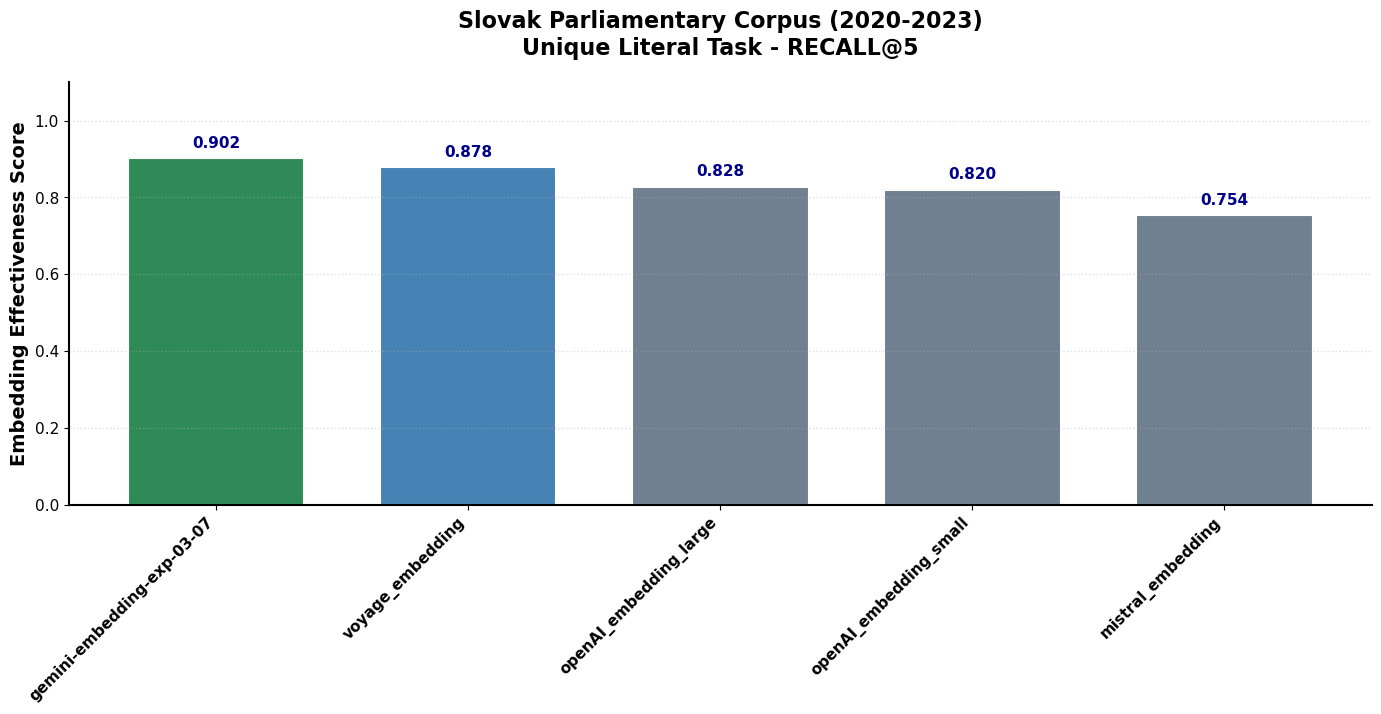

✅ Saved high-resolution graph: ../graphs/slovak_parliamentary_unique_literal_recall_at_5_embedding_effectiveness.png


C:\Users\alexe\AppData\Local\Temp\ipykernel_45108\214654017.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(sub_sorted["model"], rotation=45, ha="right", fontsize=12, fontweight='bold')


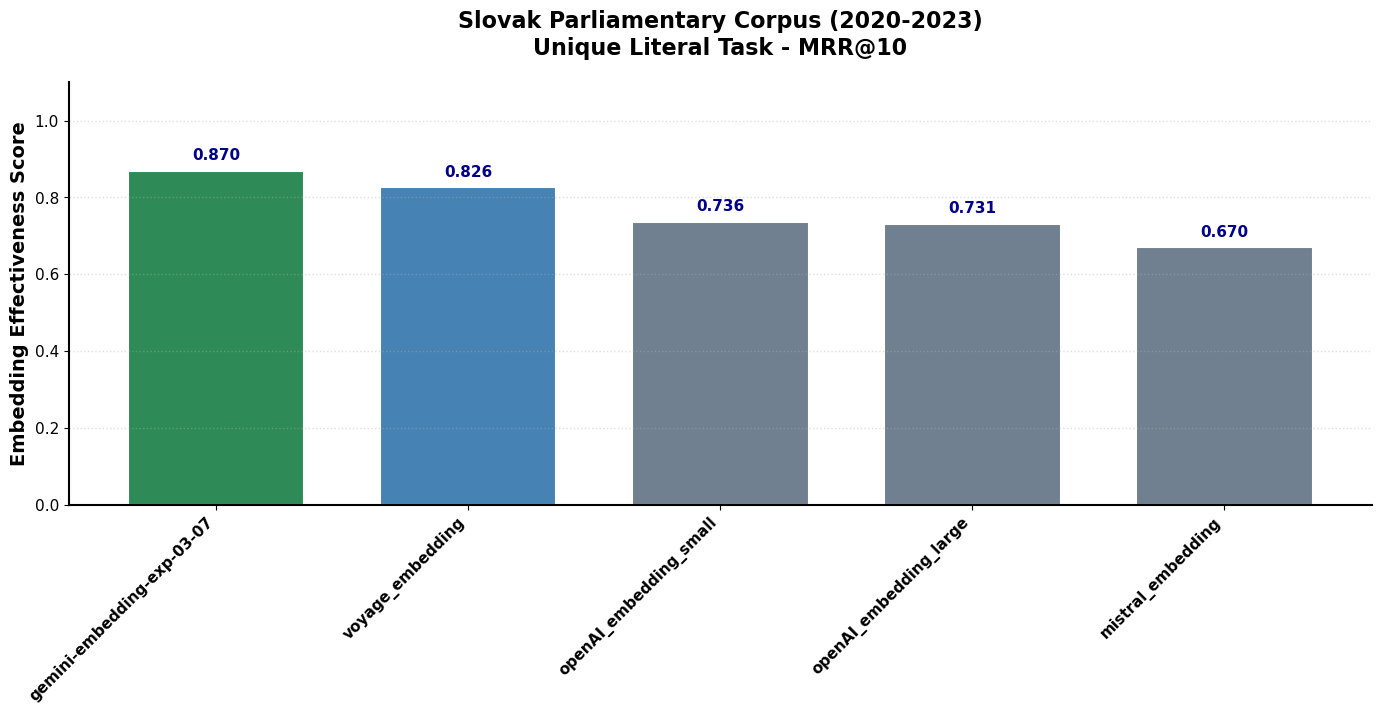

✅ Saved high-resolution graph: ../graphs/slovak_parliamentary_unique_literal_mrr_at_10_embedding_effectiveness.png


C:\Users\alexe\AppData\Local\Temp\ipykernel_45108\214654017.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(sub_sorted["model"], rotation=45, ha="right", fontsize=12, fontweight='bold')


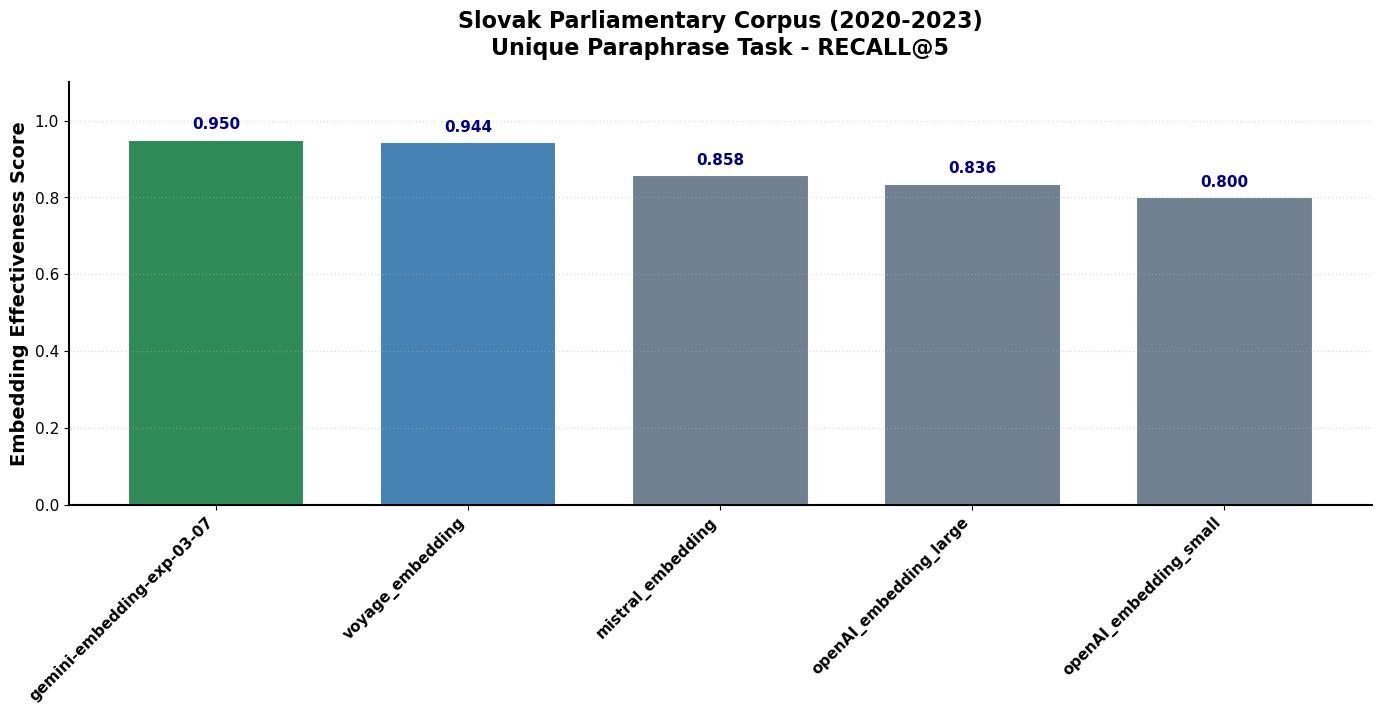

✅ Saved high-resolution graph: ../graphs/slovak_parliamentary_unique_paraphrase_recall_at_5_embedding_effectiveness.png


C:\Users\alexe\AppData\Local\Temp\ipykernel_45108\214654017.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(sub_sorted["model"], rotation=45, ha="right", fontsize=12, fontweight='bold')


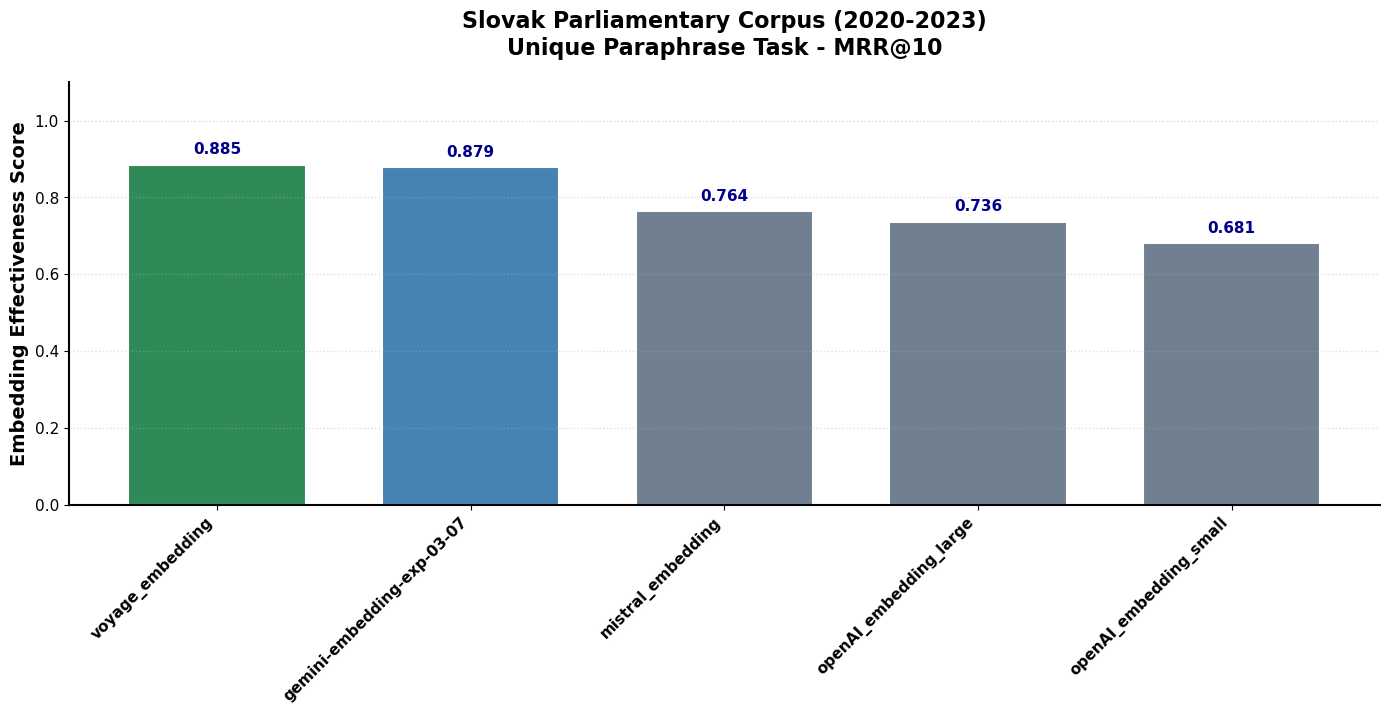

✅ Saved high-resolution graph: ../graphs/slovak_parliamentary_unique_paraphrase_mrr_at_10_embedding_effectiveness.png


C:\Users\alexe\AppData\Local\Temp\ipykernel_45108\214654017.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(sub_sorted["model"], rotation=45, ha="right", fontsize=12, fontweight='bold')


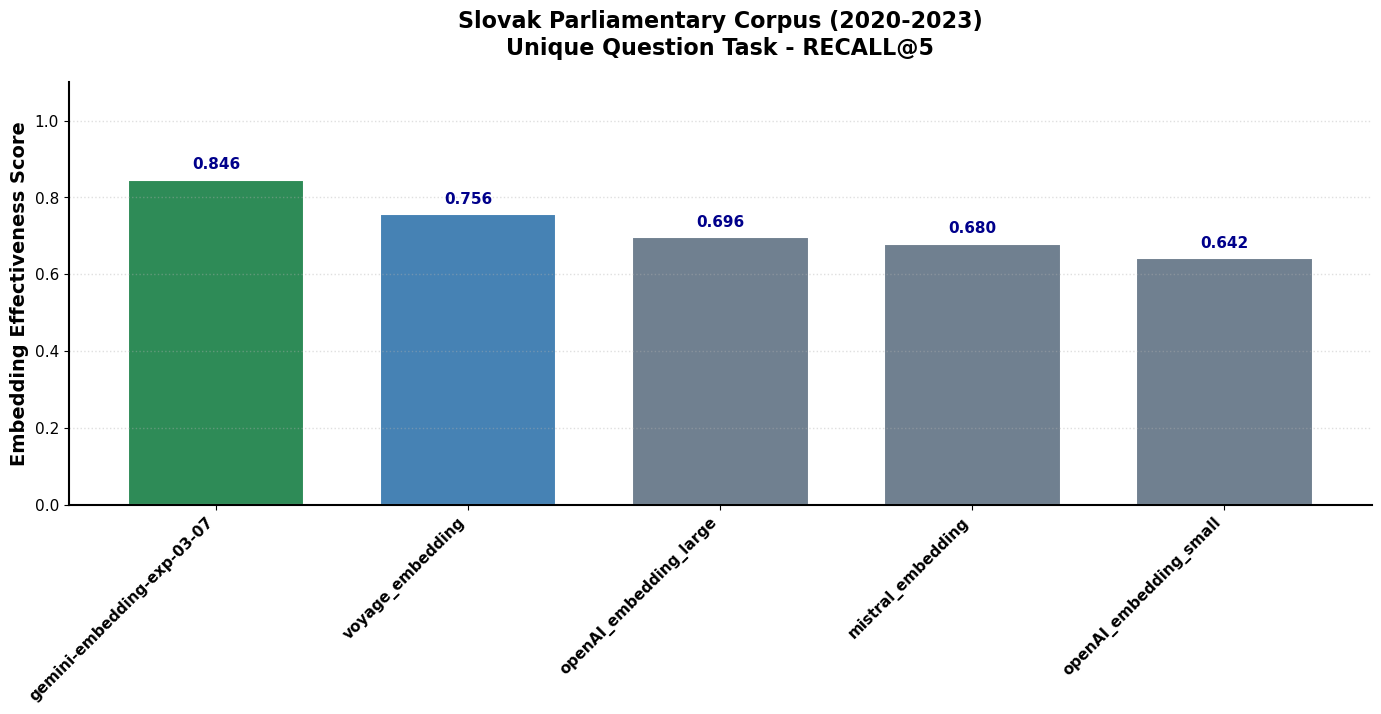

✅ Saved high-resolution graph: ../graphs/slovak_parliamentary_unique_question_recall_at_5_embedding_effectiveness.png


C:\Users\alexe\AppData\Local\Temp\ipykernel_45108\214654017.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(sub_sorted["model"], rotation=45, ha="right", fontsize=12, fontweight='bold')


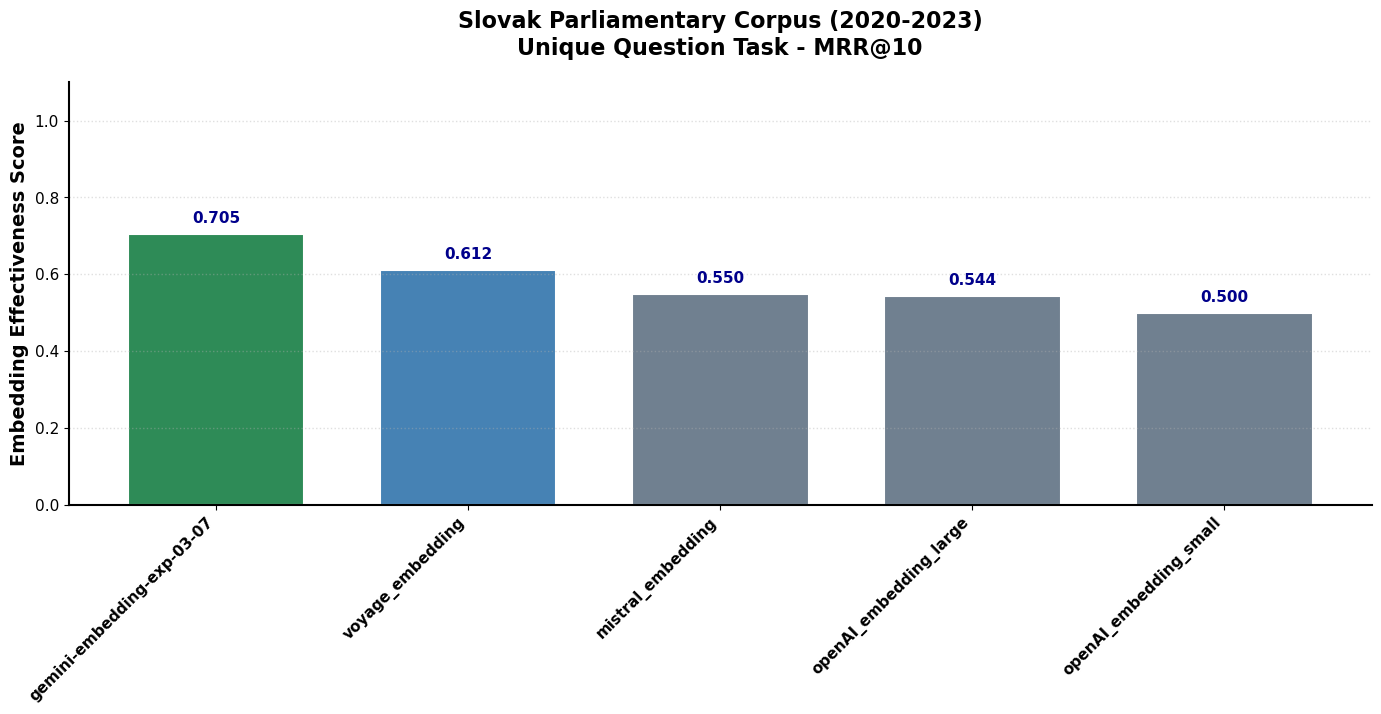

✅ Saved high-resolution graph: ../graphs/slovak_parliamentary_unique_question_mrr_at_10_embedding_effectiveness.png

📊 Slovak Parliamentary Embedding Effectiveness Summary:
📋 Total models evaluated: 5
🎯 Tasks analyzed: unique_literal, unique_paraphrase, unique_question
📈 Metrics computed: recall@5, mrr@10
🏛️ Parliamentary corpus: 2010-2023 (500 speeches)
💾 Graphs saved: 6 individual high-resolution files

🏆 Best Performing Models per Task:
  unique_literal - recall@5: gemini-embedding-exp-03-07 with score 0.902
  unique_literal - mrr@10: gemini-embedding-exp-03-07 with score 0.870
  unique_paraphrase - recall@5: gemini-embedding-exp-03-07 with score 0.950
  unique_paraphrase - mrr@10: voyage_embedding with score 0.885
  unique_question - recall@5: gemini-embedding-exp-03-07 with score 0.846
  unique_question - mrr@10: gemini-embedding-exp-03-07 with score 0.705


In [10]:
plot_benchmark_bars(all_metrics)